In [1]:
#| export

from pathlib import Path
from typing import List
from datetime import datetime, timedelta

import pandas as pd
import dask.dataframe as dd

In [2]:
from infobip_service.download import raw_data_path

In [3]:
#| export

processed_data_path = Path() / '..' / 'data' / 'processed'

In [4]:
processed_data_path.mkdir(parents=True, exist_ok=True)

In [5]:
raw_data = dd.read_parquet(raw_data_path)
raw_data.head()

,AccountId,ApplicationId,DefinitionId,OccurredTime,OccurredTimeTicks
PersonId,,,,,
0,12344,,personCreated,2023-05-22 13:47:04,1684763224886
0,12344,,personEnteredFlow,2023-05-22 14:19:33,1684765173309
0,12344,,personExitedFlow,2023-05-22 15:19:56,1684768796388
0,12344,,personEnteredFlow,2023-05-24 09:07:48,1684919268908
0,12344,,personExitedFlow,2023-05-24 10:08:16,1684922896648


## Time tresholding

In [6]:
def _sample_time_map(df: pd.DataFrame, *, time_treshold: datetime) -> pd.DataFrame:
    df = df[df['OccurredTime'] < time_treshold]
    return df

In [7]:
raw = pd.DataFrame({
        "AccountId": [12345, 12345, 12345, 12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-10 13:27:01.246912",
            "2023-07-12 13:27:02.370368",
            "2023-07-12 13:27:03.493824",
            "2023-07-12 13:27:04.617280",
            "2023-07-10 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one", "two", "two", "three"],
        "ApplicationId": [None, None, None, None, None, None],
    }, index=pd.Index([1, 2, 2, 3, 3, 3], name="PersonId"))
raw["OccurredTime"] = pd.to_datetime(raw["OccurredTime"])
raw["DefinitionId"] = raw["DefinitionId"].astype("string[pyarrow]")
raw["ApplicationId"] = raw["ApplicationId"].astype("string[pyarrow]")


expected = pd.DataFrame({
        "AccountId": [12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-10 13:27:01.246912",
            "2023-07-10 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "three"],
        "ApplicationId": [None, None, None],
    }, index=pd.Index([1, 2, 3], name="PersonId"))
expected["OccurredTime"] = pd.to_datetime(expected["OccurredTime"])
expected["DefinitionId"] = expected["DefinitionId"].astype("string[pyarrow]")
expected["ApplicationId"] = expected["ApplicationId"].astype("string[pyarrow]")

In [8]:
pd.testing.assert_frame_equal(_sample_time_map(raw, time_treshold=datetime(2023, 7, 11)), expected)

In [9]:
#| export

def sample_time_map(ddf: dd.DataFrame, *, time_treshold: datetime) -> dd.DataFrame:
    meta = _sample_time_map(ddf._meta, time_treshold=time_treshold)
    return ddf.map_partitions(_sample_time_map, time_treshold=time_treshold, meta=meta)

In [10]:
actual = sample_time_map(dd.from_pandas(raw, npartitions=2), time_treshold=datetime(2023, 7, 11)).compute()
pd.testing.assert_frame_equal(actual, expected)

### Dataset time exploration

In [11]:
time_stats = raw_data["OccurredTime"].describe().compute()
time_stats

count                         27999602
min                2023-03-29 12:59:30
25%                2023-06-15 10:01:10
50%                2023-10-17 13:10:22
75%      2023-11-28 08:59:49.321999872
max         2023-12-23 00:00:30.906000
Name: OccurredTime, dtype: string

In [12]:
# | export

# Time treshold is 56 days before the latest event. 28 days before for test horizon and 28 days more for train/validation horizon
max_time = datetime.strptime(time_stats["max"], "%Y-%m-%d %H:%M:%S.%f")
time_treshold = max_time - timedelta(days=56)
time_treshold

datetime.datetime(2023, 10, 28, 0, 0, 30, 906000)

/tmp/ipykernel_2516276/3067838444.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(factor).apply(lambda x: x.count()).plot(kind='bar', rot=45, legend=0);


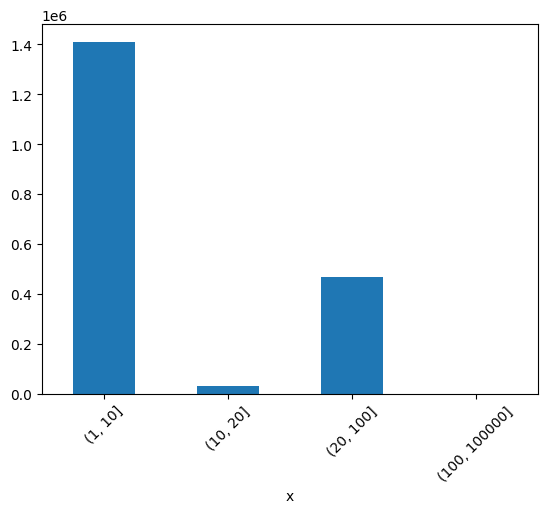

In [13]:
df = pd.DataFrame({'x':sample_time_map(raw_data, time_treshold=time_treshold).index.value_counts().compute().values})
factor = pd.cut(df.x, [1,10,20,100,100000])
df.groupby(factor).apply(lambda x: x.count()).plot(kind='bar', rot=45, legend=0);

# Sample construction

## Time to next Event buckets

In [14]:
# | export

timedelta_buckets = [timedelta(days=days) for days in [1, 3, 7, 14, 28]]

def _bin_timedelta(timedelta: timedelta, *, timedelta_buckets: List[timedelta]=timedelta_buckets):
    for class_value, timedelta_key in enumerate(timedelta_buckets):
        if timedelta < timedelta_key:
            return class_value

    return len(timedelta_buckets)

In [15]:
assert _bin_timedelta(timedelta(days=0)) == 0
assert _bin_timedelta(timedelta(days=2)) == 1
assert _bin_timedelta(timedelta(days=4)) == 2
assert _bin_timedelta(timedelta(days=8)) == 3
assert _bin_timedelta(timedelta(days=16)) == 4
assert _bin_timedelta(timedelta(days=32)) == 5

In [16]:
user_history = pd.DataFrame({
        "AccountId": [12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one"],
        "ApplicationId": [None, None, None],
    }, index=pd.Index([1, 1, 1], name="PersonId"))
user_history["OccurredTime"] = pd.to_datetime(user_history["OccurredTime"])

In [17]:
#| export

def bin_next_event_user_history(user_history: pd.DataFrame, *, t0: datetime, timedelta_buckets: List[timedelta]=timedelta_buckets):
    user_history = user_history[user_history['OccurredTime'] > t0]
    if user_history.empty:
        return len(timedelta_buckets)

    return _bin_timedelta(user_history['OccurredTime'].min() - t0, timedelta_buckets=timedelta_buckets)

In [18]:
assert bin_next_event_user_history(user_history, t0=datetime(2023, 7, 10)) == 0 # 1 day to first event
assert bin_next_event_user_history(user_history, t0=datetime(2023, 7, 9)) == 1 # 2 days to first event
assert bin_next_event_user_history(user_history, t0=datetime(2023, 6, 1)) == 5 # >28 days to first event
assert bin_next_event_user_history(user_history, t0=datetime(2023, 7, 20)) == 3 # 8 days to last event (t0 in the middle of events)

## History construction